# NAMED ENTITY RECOGNITION

Данильченко Вадим

In [72]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Embedding, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn_crfsuite.metrics import flat_classification_report

In [5]:
data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [10]:
# объявим длину последовательности
max_len = 50

# создадим уникальные словари частей речи и тэгов
words = list(set(data["Word"].values))
tags = list(set(data["Tag"].values))

# присвоим кадлому слову индекс
word2idx = {w: i + 2 for i, w in enumerate(words)}
# неизветные нам слова будут иметь индекс слова "UNK"
word2idx["UNK"] = 1
# отступы слов до достижения заданной длины последовательности 
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

# количество тэгов - размерность выходного слоя
n_tags = len(tag2idx)

In [11]:
# создадим класс для объединения датасета в кортеж (слово, часть речи, тэг)
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try:
            s = self.data[self.data["Sentence #"] == "Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist()    
        except:
            self.empty = True
            return None, None, None

In [12]:
# запишем результат в переменную
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[:2]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

In [14]:
# преобразуем предложения в последовательность индексов слов
X = [[word2idx[w[0]] for w in s] for s in sentences]
print(X[0])

[17897, 9596, 3207, 30072, 19309, 1327, 28291, 34883, 5637, 6676, 15083, 19302, 17689, 31141, 32695, 6676, 32689, 9596, 1487, 8156, 18776, 11271, 19282, 30394]


In [24]:
# добавим нули до максимального размера последовательности
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value= 0)
print(X[0])

[17897  9596  3207 30072 19309  1327 28291 34883  5637  6676 15083 19302
 17689 31141 32695  6676 32689  9596  1487  8156 18776 11271 19282 30394
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [25]:
# запишем в целевую переменную для каждого преддложения индексы его тэгов
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
print(y[0])

[ 6  6  6  6  6  6  4  6  6  6  6  6  4  6  6  6  6  6 15  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6]


In [27]:
# разделим данные на тренировочную и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]

In [34]:
# составим модель
model = Sequential()
model.add(Embedding(input_dim=len(word2idx) + 1 , output_dim=50, input_length=max_len))
model.add(Bidirectional(LSTM(100, return_sequences = True, recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [36]:
# обучим модель
history = model.fit(x_train, 
                    np.array(y_train), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.1, 
                    verbose=1)

C:\Users\vndan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 92s 2ms/step - loss: 0.1372 - accuracy: 0.9649 - val_loss: 0.0640 - val_accuracy: 0.9815
Epoch 2/10
38846/38846 [==============================] - 91s 2ms/step - loss: 0.0537 - accuracy: 0.9844 - val_loss: 0.0516 - val_accuracy: 0.9849
Epoch 3/10
38846/38846 [==============================] - 91s 2ms/step - loss: 0.0449 - accuracy: 0.9869 - val_loss: 0.0479 - val_accuracy: 0.9858
Epoch 4/10
38846/38846 [==============================] - 91s 2ms/step - loss: 0.0405 - accuracy: 0.9881 - val_loss: 0.0467 - val_accuracy: 0.9863
Epoch 5/10
38846/38846 [==============================] - 95s 2ms/step - loss: 0.0374 - accuracy: 0.9889 - val_loss: 0.0467 - val_accuracy: 0.9861
Epoch 6/10
38846/38846 [==============================] - 93s 2ms/step - loss: 0.0353 - accuracy: 0.9895 - val_loss: 0.0448 - val_accuracy: 0.9866
Epoch 7/10
38846/38846 [==============================] - 92s 2ms/ste

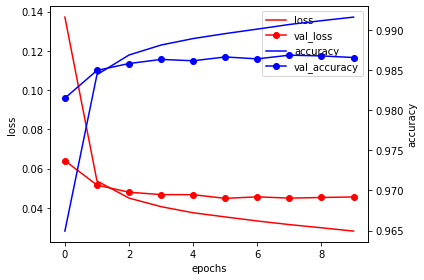

In [57]:
import matplotlib.pyplot as plt
# посмотрим на историю обучения

fig, ax1 = plt.subplots()

t = np.arange(0, len(history.history['accuracy']), 1)

ln1 = ax1.plot(t, history.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, history.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, history.history['accuracy'], color='b', label='accuracy')
ln4 = ax2.plot(t, history.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [74]:
# посмотрим на результаты классификации в разрезе каждой именованной сущности
pred = model.predict(x_test)
pred_classes = pred.argmax(axis=-1)
report = flat_classification_report(y_pred=pred_classes, y_true=y_test, target_names=tags)
print(report)

C:\Users\vndan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-eve       0.83      0.38      0.53        26
       I-gpe       0.92      0.55      0.69        20
       B-nat       0.71      0.38      0.50        13
       B-geo       0.88      0.89      0.88      3810
       B-per       0.85      0.82      0.84      1657
           O       1.00      1.00      1.00    223780
       I-art       0.25      0.13      0.17        23
       I-per       0.86      0.88      0.87      1683
       B-org       0.75      0.75      0.75      2093
       B-art       0.31      0.13      0.18        39
       I-tim       0.81      0.75      0.78       616
       I-nat       0.00      0.00      0.00         2
       I-eve       0.17      0.08      0.11        13
       B-tim       0.93      0.87      0.89      1989
       B-gpe       0.97      0.96      0.96      1562
       I-org       0.78      0.81      0.79      1733
       I-geo       0.83      0.79      0.81       741

    accuracy              